# 1. 필요한 패키지 로드

In [4]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

from IPython.display import clear_output
from PIL import Image

import os
import time
import re
from glob import glob
import shutil
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow.keras import layers

print('tensorflow version: {}'.format(tf.__version__))

tensorflow version: 2.1.0


# 2. 데이터셋 경로, 파라미터 선언

In [6]:
data_dir = './data/dataset'  # 압축 해제된 데이터셋의 디렉토리 경로
print_steps = 1
val_epoch = 1

batch_size = 20
max_epochs = 20
learning_rate = 1e-4
IMG_SIZE = 150

PATH = data_dir

# 3. Input pipeline , 데이터 증식 함수 선언 

In [7]:
 # 해당경로의 파일을 읽어서 float 타입으로 변환하는 함수
def load(image_file, label):
   
    image = tf.io.read_file(image_file)
    image = tf.image.decode_jpeg(image)
    image = tf.cast(image, tf.float32)

    return image, label

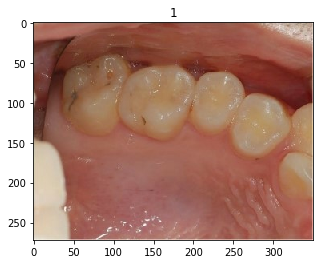

In [9]:
#확인용 코드
image, label = load(os.path.join(PATH, 'train/cavity/1.jpg'), 1)
plt.figure()
plt.title(label)
plt.imshow(image/255.0)
plt.show()

In [10]:
  # 원하는 height와 width로 이미지를 resize 하는 함수
def resize(input_image, height, width):
  
    input_image = tf.image.resize(input_image,[height,width])

    return input_image

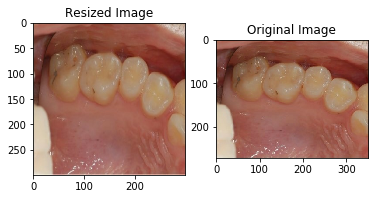

In [12]:
#확인용 코드
plt.figure()
plt.subplot(121)
plt.title("Resized Image")
plt.imshow(resize(image, 300, 300)/255.0)
plt.subplot(122)
plt.title("Original Image")
plt.imshow(image/255.0)
plt.show()

In [13]:
 # 이미지를 랜덤한 각도(radian)로 회전 시키는 함수
def random_rotation(input_image):
   
    angles = np.random.randint(3)
    rotated_image = tf.image.rot90(input_image,angles)

    return rotated_image

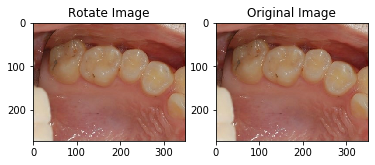

In [21]:
#확인용 코드
plt.figure()
plt.subplot(121)
plt.title("Rotate Image")
plt.imshow(random_rotation(image)/255.0)
plt.subplot(122)
plt.title("Original Image")
plt.imshow(image/255.0)
plt.show()

In [22]:
#영역 추출 함수
def random_crop(input_image):

    cropped_image = tf.image.random_crop(input_image,[150,150,3])

    return cropped_image

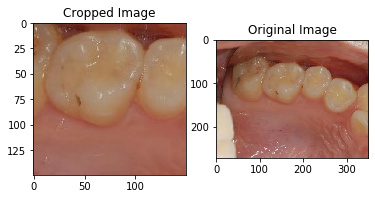

In [24]:
#확인용 코드
plt.figure()
plt.subplot(121)
plt.title("Cropped Image")
plt.imshow(random_crop(image)/255.0)
plt.subplot(122)
plt.title("Original Image")
plt.imshow(image/255.0)
plt.show()

In [25]:
# 이미지 픽셀값의 범위를 normalize 하는 함수 [0, 255] -> [-1, 1]
def normalize(input_image):
  

    input_image = (input_image/255)-1

    return input_image

In [26]:
 # resize, random_crop, random_rotation, random_flip 함수들 통합 함수
def random_jitter(input_image):
   
    input_image = resize(input_image,176,176)
    input_image = random_crop(input_image)
    input_image = random_rotation(input_image)    
    input_image = tf.image.random_flip_left_right(input_image)

    return input_image

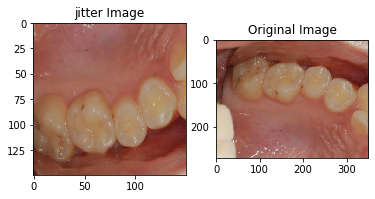

In [30]:
#확인용 코드
plt.figure()
plt.subplot(121)
plt.title("jitter Image")
plt.imshow(random_jitter(image)/255.0)
plt.subplot(122)
plt.title("Original Image")
plt.imshow(image/255.0)
plt.show()

In [31]:
# 176 x 176 으로 resize후 150 x 150 중앙 crop 하는 함수
def central_crop(input_image):

    input_image = resize(input_image,176,176)
    input_image = tf.image.central_crop(input_image,0.85)

    return input_image

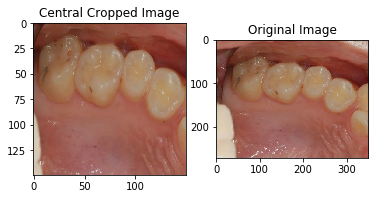

In [32]:
#확인용 코드
plt.figure()
plt.subplot(121)
plt.title("Central Cropped Image")
plt.imshow(central_crop(image)/255.0)
plt.subplot(122)
plt.title("Original Image")
plt.imshow(image/255.0)
plt.show()

In [35]:
#훈련 데이터 Input pipeline
def load_image_train(image_file, label):

    input_image, label = load(image_file,label)
    input_image = random_jitter(input_image)
    input_image = normalize(input_image)

    return input_image, label

In [36]:
#검증, 테스트 데이터 Input pipeline
def load_image_val_and_test(image_file, label):

    input_image, label = load(image_file,label)
    input_image = central_crop(input_image)
    input_image = normalize(input_image)

    return input_image, label

# 4. 데이터셋 

In [37]:
#라벨 붙이는 함수, 충치는 0 정상은 1
def add_label(image_file, label):
    return image_file, label

In [38]:
# train folder에 있는 폴더 이름을 list로 나타냅니다.
folder_list = [f for f in os.listdir(os.path.join(PATH, 'train')) if not f.startswith('.')]

1. `tf.data.Dataset.list_files`을 이용하여 첫번째 폴더('cavity')에 있는 `*.jpg`의 파일이름을 가져와서 `train_dataset`으로 만듭니다.
2. 해당 `dataset`에 `tf.data.Dataset.map`함수를 이용하여 label(0)을 추가합니다.
3. for문을 통해 `folder_list`에 있늘 폴더들을 두번째 부터 읽어옵니다.
4. `tf.data.Dataset.list_files`을 이용하여 두번째 폴더('normal')에 있는 `*.jpg`의 파일이름을 가져와서 `temp_dataset`으로 만듭니다.
5. 해당 `dataset`에 `tf.data.Dataset.map`함수를 이용하여 label(1)을 추가합니다.
6. `train_dataset`('cavity' 데이터)와 `temp_dataset`('normal' 데이터)를 `tf.data.Dataset.concatenate`를 이용하여 합칩니다.
7. for문을 반복합니다. (각 카테고리의 데이터와 label이 차례로 `train_dataset`에 합쳐집니다.)

In [39]:
train_dataset = tf.data.Dataset.list_files(                            # 1번
    os.path.join(PATH, 'train', folder_list[0], '*.jpg'))
train_dataset = train_dataset.map(lambda x: add_label(x, 0))          # 2번
for label, category_name in enumerate(folder_list[1:], 1):            # 3번
    temp_dataset = tf.data.Dataset.list_files(                         # 4번
        os.path.join(PATH, 'train', category_name, '*.jpg'))
    temp_dataset = temp_dataset.map(lambda x: add_label(x, label))    # 5번
    train_dataset = train_dataset.concatenate(temp_dataset)            # 6번

In [40]:
N = BUFFER_SIZE = len(list(train_dataset)) 
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.map(load_image_train,
                                  num_parallel_calls=16)
train_dataset = train_dataset.batch(batch_size)
train_dataset = train_dataset.repeat()

In [41]:
folder_list = [f for f in os.listdir(os.path.join(PATH, 'val')) if not f.startswith('.')]
val_dataset = tf.data.Dataset.list_files(os.path.join(PATH, 'val', folder_list[0], '*.jpg'))
val_dataset = val_dataset.map(lambda x: add_label(x, 0))
for label, category_name in enumerate(folder_list[1:], 1):
    temp_dataset = tf.data.Dataset.list_files(os.path.join(PATH, 'val', category_name, '*.jpg'))
    temp_dataset = temp_dataset.map(lambda x: add_label(x, label))
    val_dataset = val_dataset.concatenate(temp_dataset)

val_dataset = val_dataset.map(load_image_val_and_test)
val_dataset = val_dataset.batch(batch_size)
val_dataset = val_dataset.repeat()

In [42]:
folder_list = [f for f in os.listdir(os.path.join(PATH, 'test')) if not f.startswith('.')]
test_dataset = tf.data.Dataset.list_files(os.path.join(PATH, 'test', folder_list[0], '*.jpg'))
test_dataset = test_dataset.map(lambda x: add_label(x, 0))
for label, category_name in enumerate(folder_list[1:], 1):
    temp_dataset = tf.data.Dataset.list_files(os.path.join(PATH, 'test', category_name, '*.jpg'))
    temp_dataset = temp_dataset.map(lambda x: add_label(x, label))
    test_dataset = test_dataset.concatenate(temp_dataset)

test_dataset = test_dataset.map(load_image_val_and_test)
test_dataset = test_dataset.shuffle(BUFFER_SIZE)
test_dataset = test_dataset.batch(batch_size)
test_dataset = test_dataset.repeat()

# 5. 네트워크 설계

In [46]:
class Conv(tf.keras.Model):
    def __init__(self, filters, kernel_size):
        super(Conv, self).__init__()

        self.conv = tf.keras.layers.Conv2D(filters = filters, kernel_size = kernel_size)
        self.bn = tf.keras.layers.BatchNormalization() 
        self.relu = tf.keras.layers.ReLU()
        self.pool = tf.keras.layers.MaxPool2D()

    def call(self, inputs, training=True):

        x = self.conv(inputs)  
        x = self.bn(x,training=training)    
        x = self.relu(x)    
        x = self.pool(x)    

        return x

In [47]:
model = tf.keras.Sequential()

model.add(Conv(filters=32, kernel_size=3))
model.add(Conv(filters=64, kernel_size=3))
model.add(Conv(filters=128, kernel_size=3))
model.add(Conv(filters=128, kernel_size=3))

model.add(tf.keras.layers.Flatten())  
model.add(tf.keras.layers.Dense(512, activation=tf.nn.relu))  
model.add(tf.keras.layers.Dense(2, activation=tf.nn.softmax))  

In [49]:
model(images[:1])

<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[0.50935215, 0.4906478 ]], dtype=float32)>

In [50]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv (Conv)                  multiple                  1024      
_________________________________________________________________
conv_1 (Conv)                multiple                  18752     
_________________________________________________________________
conv_2 (Conv)                multiple                  74368     
_________________________________________________________________
conv_3 (Conv)                multiple                  148096    
_________________________________________________________________
flatten (Flatten)            multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  3211776   
_________________________________________________________________
dense_1 (Dense)              multiple                  1

# 모델 저장

In [75]:
checkpoint_path = "./train/exp_cnn/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_dir, save_weights_only=True, verbose=1)

# 6. Loss function 및 Optimizer 정의

In [76]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001), 
              loss = tf.keras.losses.SparseCategoricalCrossentropy(), 
              metrics = [tf.keras.metrics.CategoricalAccuracy()])

# 7. Training

In [77]:
train_len = len(glob(os.path.join(PATH, 'train', folder_list[0], '*.jpg'))) * 2
val_len = len(glob(os.path.join(PATH, 'val', folder_list[0], '*.jpg'))) * 2
test_len = len(glob(os.path.join(PATH, 'test', folder_list[0], '*.jpg'))) * 2

In [78]:
model.fit(train_dataset, steps_per_epoch = train_len/batch_size,
          validation_data=val_dataset, 
          validation_steps=val_len/batch_size ,
         epochs= max_epochs,
         callbacks= [cp_callback])

Train for 32.7 steps, validate for 30.0 steps
Epoch 1/20
32/32 [============================>.] - ETA: 0s - loss: 1.2583 - categorical_accuracy: 0.9702
Epoch 00001: saving model to ./train/exp_cnn
33/32 [==============================] - 54s 2s/step - loss: 1.2208 - categorical_accuracy: 0.9711 - val_loss: 0.1663 - val_categorical_accuracy: 1.0000
Epoch 2/20
32/32 [============================>.] - ETA: 0s - loss: 0.3101 - categorical_accuracy: 0.9890
Epoch 00002: saving model to ./train/exp_cnn
33/32 [==============================] - 50s 2s/step - loss: 0.3049 - categorical_accuracy: 0.9893 - val_loss: 0.2501 - val_categorical_accuracy: 1.0000
Epoch 3/20
32/32 [============================>.] - ETA: 0s - loss: 0.1560 - categorical_accuracy: 0.9780
Epoch 00003: saving model to ./train/exp_cnn
33/32 [==============================] - 50s 2s/step - loss: 0.1531 - categorical_accuracy: 0.9787 - val_loss: 0.2663 - val_categorical_accuracy: 1.0000
Epoch 4/20
32/32 [========================

# 8. 평가

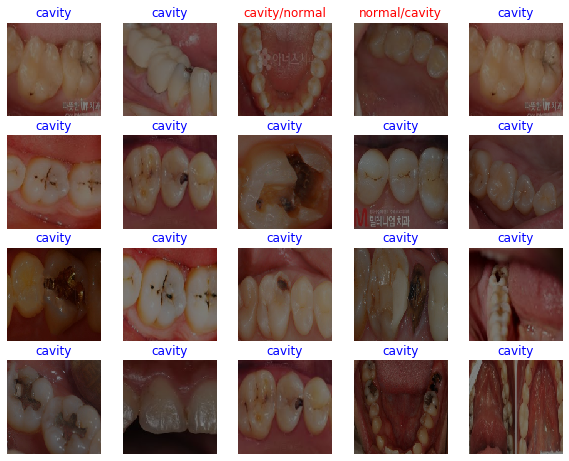

In [79]:
test_batch_size = 25

for images, labels in test_dataset.take(1):
    predictions = model(images)

images = images[:test_batch_size]
labels = labels[:test_batch_size]
predictions = predictions[:test_batch_size]

labels_map = {0: 'cavity', 1: 'normal'}

# 시각화
fig = plt.figure(figsize=(10, 10))
for i, (px, py, y_pred) in enumerate(zip(images, labels, predictions)):
    p = fig.add_subplot(5, 5, i+1)
    if np.argmax(y_pred.numpy()) == py.numpy():
        p.set_title("{}".format(labels_map[py.numpy()]), color='blue')#정답
    else:
        p.set_title("{}/{}".format(labels_map[np.argmax(y_pred.numpy())],
                                   labels_map[py.numpy()]), color='red')#오답
    p.imshow(px.numpy()*0.5+0.5)
    p.axis('off')

# 9. 저장된 모델 불러오기 및 Evaluation

In [80]:
model = tf.keras.Sequential()

model.add(Conv(filters=32, kernel_size=3))
model.add(Conv(filters=64, kernel_size=3))
model.add(Conv(filters=128, kernel_size=3))
model.add(Conv(filters=128, kernel_size=3))

model.add(tf.keras.layers.Flatten()) 
model.add(tf.keras.layers.Dense(512, activation=tf.nn.relu))
model.add(tf.keras.layers.Dense(2, activation=tf.nn.softmax)) 



model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001), 
              loss = tf.keras.losses.SparseCategoricalCrossentropy(), 
              metrics = [tf.keras.metrics.CategoricalAccuracy()])



for images, labels in train_dataset.take(1):
    outputs = model(images, training=False)

In [81]:
latest = tf.train.latest_checkpoint(checkpoint_dir)
latest

'./train/exp_cnn\\cp-0020.ckpt'

In [82]:
model.load_weights(latest)

In [83]:
model.evaluate(test_dataset, steps=test_len/batch_size)

27/26 [==============================] - 14s 500ms/step - loss: 0.1984 - categorical_accuracy: 0.9963


[0.19908174415392504, 0.9962963]

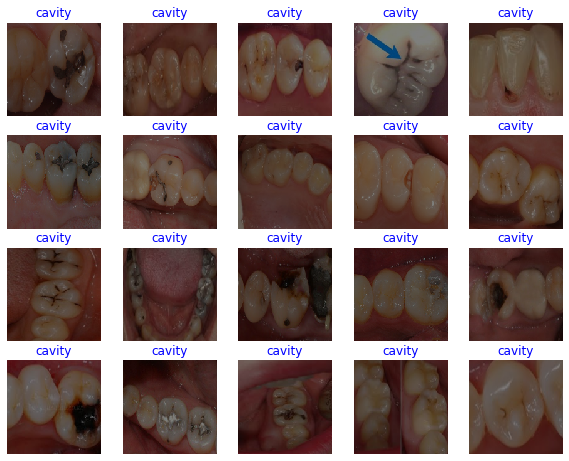

In [84]:

test_batch_size = 25

for images, labels in test_dataset.take(1):
    predictions = model(images)

images = images[:test_batch_size]
labels = labels[:test_batch_size]
predictions = predictions[:test_batch_size]

labels_map = {0: 'cavity', 1: 'normal'}

# 시각화
fig = plt.figure(figsize=(10, 10))
for i, (px, py, y_pred) in enumerate(zip(images, labels, predictions)):
    p = fig.add_subplot(5, 5, i+1)
    if np.argmax(y_pred.numpy()) == py.numpy():
        p.set_title("{}".format(labels_map[py.numpy()]), color='blue')#정답
    else:
        p.set_title("{}/{}".format(labels_map[np.argmax(y_pred.numpy())],
                                   labels_map[py.numpy()]), color='red')#오답
    p.imshow(px.numpy()*0.5+0.5)
    p.axis('off')